# Preprocessing

In [2]:
import geopandas as gpd
import glob
import os
from bisect import bisect_left, bisect_right
from os import listdir
from os.path import isfile, join
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from rasterio.mask import mask
import rasterio
from fiona.crs import from_epsg
from shapely.geometry import box
from pyproj import Transformer
import pycrs
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm

In [13]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [14]:
# import points
points_fire = gpd.read_file('../GIS/points_fire_sample.shp')
points_nofire = gpd.read_file('../GIS/points_nofire_sample.shp')

In [35]:
# import moisture maps
path = '../Data/lfmc_folder_250'
filenames = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.tif')]

# get dates of map
dates = [f.split("map_")[1].split(".tif")[0] for f in filenames]
dates = [datetime.strptime(date_string, "%Y-%m-%d").date() for date_string in dates]
dates = sorted(dates)

### Fire Tiles

In [22]:
out_path = "../Data/fire"

for i in range(len(points_fire)):
    
    # get fire date
    fire_date = points_fire['IgntDate'].iloc[i]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
#     print(fire_date)
    
    # get closest map to fire date
    nearest_date = dates[:bisect_left(dates, fire_date)][-1]
    nearest_date = nearest_date.strftime('%Y-%m-%d')
    
    # get file corresponding to nearest date
    file = "lfmc_map_{}.tif".format(nearest_date)
    
    # Input raster
    fp = os.path.join(path, file)

    # Read the data
    data = rasterio.open(fp)
    
    # Crop image to have coordinate in center
    x_center = points_fire['geometry'].iloc[i].x
    y_center = points_fire['geometry'].iloc[i].y

    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    x_center, y_center = transformer.transform(x_center,y_center)

    xmin = x_center - 16 * data.transform[4] # pixel size
    xmax = x_center + 15 * data.transform[4]
    ymin = y_center - 16 * (-data.transform[0])
    ymax = y_center + 15 * (-data.transform[0])
    
    # create bounding box
    bbox = box(ymin, xmin, ymax, xmax)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs = data.crs.data)
    
    coords = getFeatures(geo)
    
    # Save cropped image
    out_tif = os.path.join(out_path, 'fire_{}.tif'.format(i))
    print(out_tif)
    
    # Clip the raster with Polygon
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
#     print(' Tile {} out of {}'.format(i, len(points_fire)))

../Data/processed_dataset2/fire_0.tif
../Data/processed_dataset2/fire_1.tif
../Data/processed_dataset2/fire_2.tif
../Data/processed_dataset2/fire_3.tif
../Data/processed_dataset2/fire_4.tif
../Data/processed_dataset2/fire_5.tif
../Data/processed_dataset2/fire_6.tif
../Data/processed_dataset2/fire_7.tif
../Data/processed_dataset2/fire_8.tif
../Data/processed_dataset2/fire_9.tif
../Data/processed_dataset2/fire_10.tif
../Data/processed_dataset2/fire_11.tif
../Data/processed_dataset2/fire_12.tif
../Data/processed_dataset2/fire_13.tif
../Data/processed_dataset2/fire_14.tif
../Data/processed_dataset2/fire_15.tif
../Data/processed_dataset2/fire_16.tif
../Data/processed_dataset2/fire_17.tif
../Data/processed_dataset2/fire_18.tif
../Data/processed_dataset2/fire_19.tif
../Data/processed_dataset2/fire_20.tif
../Data/processed_dataset2/fire_21.tif
../Data/processed_dataset2/fire_22.tif
../Data/processed_dataset2/fire_23.tif
../Data/processed_dataset2/fire_24.tif
../Data/processed_dataset2/fire_25.

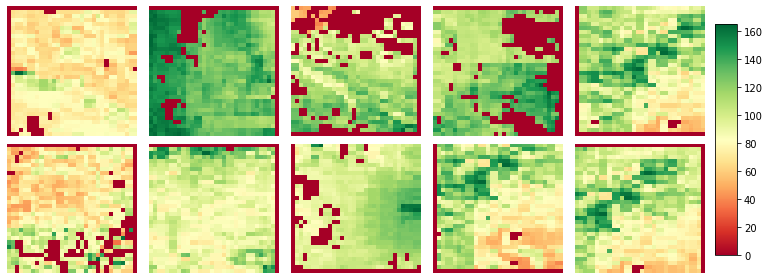

In [131]:
# Visualize some images
out_path = "../Data/fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

### Non-Fire Tiles

In [87]:
out_path = "../Data/nofire"

# for i in range(len(points_fire)):
for i in range(800):
    
    # get fire date
    idx = random.randint(0, len(points_fire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    # get file corresponding to nearest date
    file = "lfmc_map_{}.tif".format(chosen_date)
    
    # Input raster
    fp = os.path.join(path, file)

    # Read the data
    data = rasterio.open(fp)
    
    # Crop image to have coordinate in center
    x_center = points_fire['geometry'].iloc[idx].x
    y_center = points_fire['geometry'].iloc[idx].y

    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    x_center, y_center = transformer.transform(x_center,y_center)

    xmin = x_center - 16 * data.transform[4] # pixel size
    xmax = x_center + 15 * data.transform[4]
    ymin = y_center - 16 * (-data.transform[0])
    ymax = y_center + 15 * (-data.transform[0])
    
    # create bounding box
    bbox = box(ymin, xmin, ymax, xmax)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs = data.crs.data)
    
    coords = getFeatures(geo)
    
    # Save cropped image
    out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
    print(out_tif)
    
    # Clip the raster with Polygon
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

../Data/nofire/nofire_0.tif
../Data/nofire/nofire_1.tif
../Data/nofire/nofire_2.tif
../Data/nofire/nofire_3.tif
../Data/nofire/nofire_4.tif
../Data/nofire/nofire_5.tif
../Data/nofire/nofire_6.tif
../Data/nofire/nofire_7.tif
../Data/nofire/nofire_8.tif
../Data/nofire/nofire_9.tif
../Data/nofire/nofire_10.tif
../Data/nofire/nofire_11.tif
../Data/nofire/nofire_12.tif
../Data/nofire/nofire_13.tif
../Data/nofire/nofire_14.tif
../Data/nofire/nofire_15.tif
../Data/nofire/nofire_16.tif
../Data/nofire/nofire_17.tif
../Data/nofire/nofire_18.tif
../Data/nofire/nofire_19.tif
../Data/nofire/nofire_20.tif
../Data/nofire/nofire_21.tif
../Data/nofire/nofire_22.tif
../Data/nofire/nofire_23.tif
../Data/nofire/nofire_24.tif
../Data/nofire/nofire_25.tif
../Data/nofire/nofire_26.tif
../Data/nofire/nofire_27.tif
../Data/nofire/nofire_28.tif
../Data/nofire/nofire_29.tif
../Data/nofire/nofire_30.tif
../Data/nofire/nofire_31.tif
../Data/nofire/nofire_32.tif
../Data/nofire/nofire_33.tif
../Data/nofire/nofire_34

In [90]:
# For non-fire points
out_path = "../Data/nofire"

# for i in range(len(points_fire)):
for i in range(801,1601):
    
    # get fire date
    idx = random.randint(0, len(points_nofire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    # get file corresponding to nearest date
    file = "lfmc_map_{}.tif".format(chosen_date)
    
    # Input raster
    fp = os.path.join(path, file)

    # Read the data
    data = rasterio.open(fp)
    
    # Crop image to have coordinate in center
    x_center = points_fire['geometry'].iloc[idx].x
    y_center = points_fire['geometry'].iloc[idx].y

    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    x_center, y_center = transformer.transform(x_center,y_center)

    xmin = x_center - 16 * data.transform[4] # pixel size
    xmax = x_center + 15 * data.transform[4]
    ymin = y_center - 16 * (-data.transform[0])
    ymax = y_center + 15 * (-data.transform[0])
    
    # create bounding box
    bbox = box(ymin, xmin, ymax, xmax)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs = data.crs.data)
    
    coords = getFeatures(geo)
    
    # Save cropped image
    out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
    print(out_tif)
    
    # Clip the raster with Polygon
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

../Data/nofire/nofire_801.tif
../Data/nofire/nofire_802.tif
../Data/nofire/nofire_803.tif
../Data/nofire/nofire_804.tif
../Data/nofire/nofire_805.tif
../Data/nofire/nofire_806.tif
../Data/nofire/nofire_807.tif
../Data/nofire/nofire_808.tif
../Data/nofire/nofire_809.tif
../Data/nofire/nofire_810.tif
../Data/nofire/nofire_811.tif
../Data/nofire/nofire_812.tif
../Data/nofire/nofire_813.tif
../Data/nofire/nofire_814.tif
../Data/nofire/nofire_815.tif
../Data/nofire/nofire_816.tif
../Data/nofire/nofire_817.tif
../Data/nofire/nofire_818.tif
../Data/nofire/nofire_819.tif
../Data/nofire/nofire_820.tif
../Data/nofire/nofire_821.tif
../Data/nofire/nofire_822.tif
../Data/nofire/nofire_823.tif
../Data/nofire/nofire_824.tif
../Data/nofire/nofire_825.tif
../Data/nofire/nofire_826.tif
../Data/nofire/nofire_827.tif
../Data/nofire/nofire_828.tif
../Data/nofire/nofire_829.tif
../Data/nofire/nofire_830.tif
../Data/nofire/nofire_831.tif
../Data/nofire/nofire_832.tif
../Data/nofire/nofire_833.tif
../Data/no

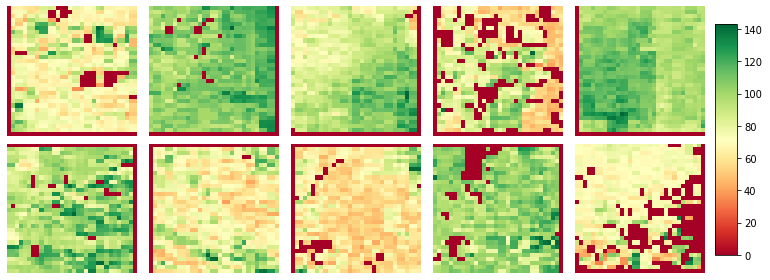

In [135]:
# Visualize some images
out_path = "../Data/nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

### Split into Train and Val Folders

In [4]:
import splitfolders
splitfolders.ratio("../Data/input_data", output="../Data/processed_data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 3528 files [00:02, 1470.81 files/s]


# Combine Images based on Time (3 months)

In [144]:
out_path = "../Data/3months_fire"

for i in range(len(points_fire)):
# for i in range(1):

    # get fire date
    fire_date = points_fire['IgntDate'].iloc[i]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
#     print(fire_date)
    
    dates_list = []
    
    # get closest map to fire date
    nearest_date = dates[:bisect_left(dates, fire_date)][-1]
    nearest_date_str = nearest_date.strftime('%Y-%m-%d')
    dates_list.append(nearest_date_str)
    
    # get 1 month before
    dates_list.append((nearest_date + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((nearest_date + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, len(points_fire)))
    
    for d in range(len(dates_list)):
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[i].x
        y_center = points_fire['geometry'].iloc[i].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_png = os.path.join(out_path, 'fire_{}.png'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d,:,:] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "PNG",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, # 3 bands
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_png, "w", **out_meta) as dest:
        dest.write(image_array)
        

 Tile 0 out of 1928
 Tile 1 out of 1928
 Tile 2 out of 1928
 Tile 3 out of 1928
 Tile 4 out of 1928
 Tile 5 out of 1928
 Tile 6 out of 1928
 Tile 7 out of 1928
 Tile 8 out of 1928
 Tile 9 out of 1928
 Tile 10 out of 1928
 Tile 11 out of 1928
 Tile 12 out of 1928
 Tile 13 out of 1928
 Tile 14 out of 1928
 Tile 15 out of 1928
 Tile 16 out of 1928
 Tile 17 out of 1928
 Tile 18 out of 1928
 Tile 19 out of 1928
 Tile 20 out of 1928
 Tile 21 out of 1928
 Tile 22 out of 1928
 Tile 23 out of 1928
 Tile 24 out of 1928
 Tile 25 out of 1928
 Tile 26 out of 1928
 Tile 27 out of 1928
 Tile 28 out of 1928
 Tile 29 out of 1928
 Tile 30 out of 1928
 Tile 31 out of 1928
 Tile 32 out of 1928
 Tile 33 out of 1928
 Tile 34 out of 1928
 Tile 35 out of 1928
 Tile 36 out of 1928
 Tile 37 out of 1928
 Tile 38 out of 1928
 Tile 39 out of 1928
 Tile 40 out of 1928
 Tile 41 out of 1928
 Tile 42 out of 1928
 Tile 43 out of 1928
 Tile 44 out of 1928
 Tile 45 out of 1928
 Tile 46 out of 1928
 Tile 47 out of 1928
 T

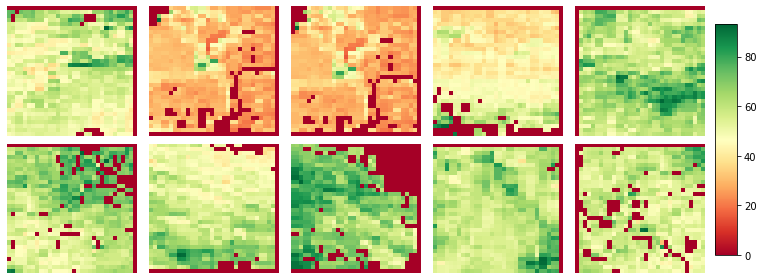

In [145]:
# Visualize some images
out_path = "../Data/3months_fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[i]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

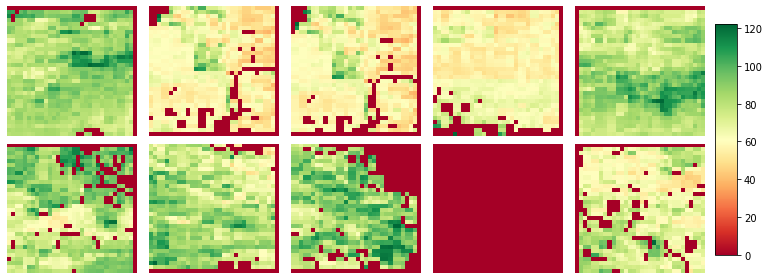

In [146]:
# Visualize some images
out_path = "../Data/3months_fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[i]))
    plt.imshow(src.read(3), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [148]:
out_path = "../Data/3months_nofire"

# for i in range(len(points_fire)):
for i in range(800):
    
    # get fire date
    idx = random.randint(0, len(points_fire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    dates_list = []
    dates_list.append(chosen_date)
    
    # get 1 month before
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, 800))
    
    for d in range(len(dates_list)):
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[idx].x
        y_center = points_fire['geometry'].iloc[idx].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_tif = os.path.join(out_path, 'nofire_{}.png'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d, :, :] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "PNG",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, 
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(image_array)

 Tile 0 out of 800
 Tile 1 out of 800
 Tile 2 out of 800
 Tile 3 out of 800
 Tile 4 out of 800
 Tile 5 out of 800
 Tile 6 out of 800
 Tile 7 out of 800
 Tile 8 out of 800
 Tile 9 out of 800
 Tile 10 out of 800
 Tile 11 out of 800
 Tile 12 out of 800
 Tile 13 out of 800
 Tile 14 out of 800
 Tile 15 out of 800
 Tile 16 out of 800
 Tile 17 out of 800
 Tile 18 out of 800
 Tile 19 out of 800
 Tile 20 out of 800
 Tile 21 out of 800
 Tile 22 out of 800
 Tile 23 out of 800
 Tile 24 out of 800
 Tile 25 out of 800
skip  ../Data/lfmc_folder_250/lfmc_map_2016-03-01.tif
skip  ../Data/lfmc_folder_250/lfmc_map_2016-02-01.tif
 Tile 26 out of 800
skip  ../Data/lfmc_folder_250/lfmc_map_2016-03-15.tif
 Tile 27 out of 800
 Tile 28 out of 800
 Tile 29 out of 800
 Tile 30 out of 800
 Tile 31 out of 800
 Tile 32 out of 800
 Tile 33 out of 800
 Tile 34 out of 800
 Tile 35 out of 800
 Tile 36 out of 800
 Tile 37 out of 800
 Tile 38 out of 800
 Tile 39 out of 800
 Tile 40 out of 800
 Tile 41 out of 800
 Tile 42

In [150]:
# For non-fire points
out_path = "../Data/3months_nofire"

# for i in range(len(points_fire)):
for i in range(801,1601):
    
    # get fire date
    idx = random.randint(0, len(points_nofire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    dates_list = []
    dates_list.append(chosen_date)
    
    # get 1 month before
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, 800))
    
    for d in range(len(dates_list)):
    
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[idx].x
        y_center = points_fire['geometry'].iloc[idx].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_tif = os.path.join(out_path, 'nofire_{}.png'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d, :, :] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "PNG",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, 
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(image_array)

 Tile 801 out of 800
 Tile 802 out of 800
 Tile 803 out of 800
 Tile 804 out of 800
 Tile 805 out of 800
 Tile 806 out of 800
 Tile 807 out of 800
 Tile 808 out of 800
 Tile 809 out of 800
 Tile 810 out of 800
 Tile 811 out of 800
 Tile 812 out of 800
 Tile 813 out of 800
 Tile 814 out of 800
 Tile 815 out of 800
 Tile 816 out of 800
 Tile 817 out of 800
 Tile 818 out of 800
 Tile 819 out of 800
skip  ../Data/lfmc_folder_250/lfmc_map_2016-03-15.tif
 Tile 820 out of 800
skip  ../Data/lfmc_folder_250/lfmc_map_2016-03-01.tif
skip  ../Data/lfmc_folder_250/lfmc_map_2016-02-01.tif
 Tile 821 out of 800
 Tile 822 out of 800
 Tile 823 out of 800
 Tile 824 out of 800
 Tile 825 out of 800
 Tile 826 out of 800
 Tile 827 out of 800
 Tile 828 out of 800
 Tile 829 out of 800
 Tile 830 out of 800
 Tile 831 out of 800
skip  ../Data/lfmc_folder_250/lfmc_map_2016-03-15.tif
skip  ../Data/lfmc_folder_250/lfmc_map_2016-02-15.tif
 Tile 832 out of 800
 Tile 833 out of 800
 Tile 834 out of 800
 Tile 835 out of

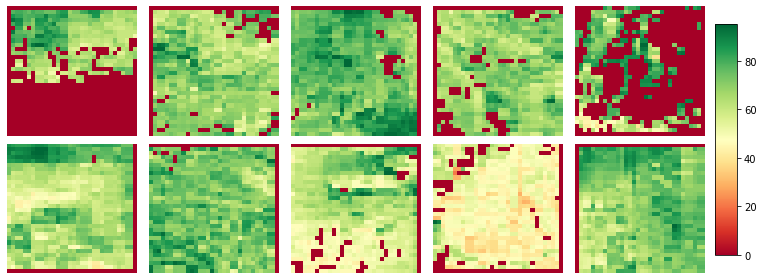

In [152]:
# Visualize some images
out_path = "../Data/3months_nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
#     idx = random.randint(0, len(images))
    idx = i + 50
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(3), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

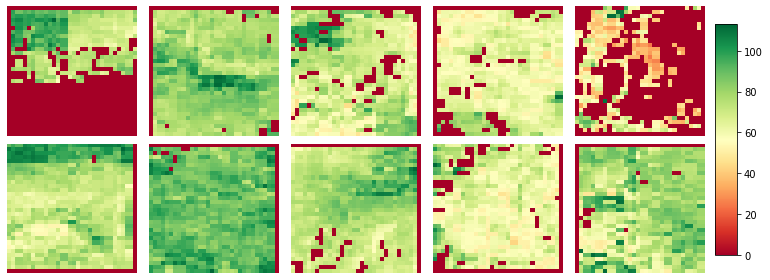

In [153]:
# Visualize some images
out_path = "../Data/3months_nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
#     idx = random.randint(0, len(images))
    idx = i + 50
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [154]:
import splitfolders
splitfolders.ratio("../Data/3months_png", output="../Data/processed_3months_data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 3457 files [00:03, 975.57 files/s] 
